<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [11]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Import Libraries

In [6]:
import pandas as pd
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gc
start = time.time()

# Load Dataset

In [7]:
transactions = pd.read_csv('C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\DataSubsets\\subset_1.csv')
transactions.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_0e171c1b48,69,N,0,A,879,M_ID_00a6ca8a8a,-1,-0.728876,2018-01-05 22:00:55,1.0,9,29
1,Y,C_ID_0e171c1b48,277,N,0,A,703,M_ID_4d6321ce13,-1,-0.662759,2018-01-27 14:21:02,4.0,13,29
2,Y,C_ID_0e171c1b48,277,N,0,A,683,M_ID_22360595e6,-11,-0.730379,2017-03-15 21:58:49,4.0,13,34
3,Y,C_ID_0e171c1b48,277,N,0,A,561,M_ID_67ead1197d,-3,-0.694315,2017-11-17 21:40:14,4.0,13,7
4,N,C_ID_0e171c1b48,277,N,0,A,511,M_ID_0f8e964477,-10,-0.740146,2017-04-12 23:31:50,4.0,13,7


In [12]:
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['purchase_amount1'] = transactions['purchase_amount']

In [13]:
transactions.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
purchase_amount1               float64
dtype: object

# Preprocessing and EDA

## Handling Outliers in Purchase Amount

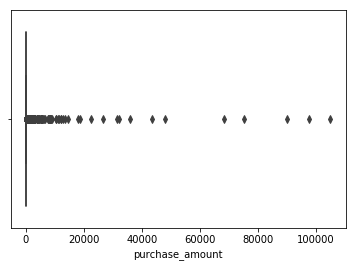

count    3.107342e+06
mean    -2.206008e-01
std      1.283000e+02
min     -7.469078e-01
25%     -7.199502e-01
50%     -6.875681e-01
75%     -6.010154e-01
max      1.050397e+05
Name: purchase_amount, dtype: float64

In [14]:
sns.boxplot(x = transactions['purchase_amount'])
plt.show()
transactions['purchase_amount'].describe()

## Adjust Purchase Amount

In [15]:
min_max = transactions['purchase_amount1'].quantile([0, 0.999]).reset_index(drop = True)
print(min_max)
transactions['purchase_amount1'][transactions['purchase_amount1'] > min_max[1]] = min_max[1]
transactions['purchase_amount1'] = transactions['purchase_amount1']+(-min_max[0])

0   -0.746908
1    6.766348
Name: purchase_amount1, dtype: float64


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


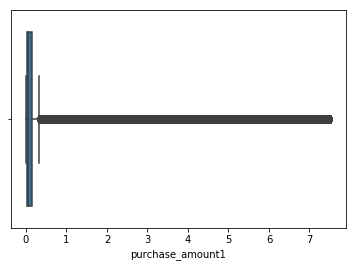

In [16]:
sns.boxplot(x = transactions['purchase_amount1'])
plt.show()

# Feature Extraction

### Extract Month

In [17]:
transactions['purchase_month'] = transactions['purchase_date'].dt.month
transactions['purchase_amount1'] = transactions['purchase_amount']

### Extract Week And Year

In [18]:
transactions['week_of_year'] = transactions['purchase_date'].dt.week
transactions['year'] = transactions['purchase_date'].dt.year

### Monthly Transaction Analysis

In [19]:
########## Each Customer's Each Month's purchase_amount and purchase_count ###########

stats = ['min','max','mean','count','var','std']
trans_amount_stats = transactions.groupby(['card_id','purchase_month']).agg({'purchase_amount1':'sum','merchant_id':'count'}).reset_index()
trans_amount_stats.columns = ['card_id', 'purchase_month', 'purchase_amount1', 'purchase_count']
print(trans_amount_stats.head())

######### Eqach Customer's stats ['min','max','mean','count','var','std']  Of  purchase_amount and Purchase_count

trans_amount_stats = trans_amount_stats.groupby(['card_id']).agg({'purchase_amount1':stats,'purchase_count':stats})
trans_amount_stats.columns = [x[0]+"_"+x[1] for x in trans_amount_stats.columns]
trans_amount_stats = trans_amount_stats.reset_index()
trans_amount_stats.head()

           card_id  purchase_month  purchase_amount1  purchase_count
0  C_ID_00007093c1               1         -5.686047              10
1  C_ID_00007093c1               2         -7.584752              16
2  C_ID_00007093c1               3         -5.712629              10
3  C_ID_00007093c1               4         -7.837212              14
4  C_ID_00007093c1               5         -3.425248              10


,card_id,purchase_amount1_min,purchase_amount1_max,purchase_amount1_mean,purchase_amount1_count,purchase_amount1_var,purchase_amount1_std,purchase_count_min,purchase_count_max,purchase_count_mean,purchase_count_count,purchase_count_var,purchase_count_std
0,C_ID_00007093c1,-10.423035,-2.946293,-6.514464,12,6.601799,2.569397,5,19,12.583333,12,20.083333,4.481443
1,C_ID_0001238066,-21.442877,-1.302784,-10.912157,8,41.524218,6.443929,2,37,18.500000,8,124.857143,11.173949
2,C_ID_0001506ef0,-11.071218,0.034381,-3.277203,11,12.388843,3.519779,1,18,6.090909,11,27.890909,5.281184
3,C_ID_0001793786,-10.843852,2.091705,-3.084636,12,21.121070,4.595767,2,38,20.583333,12,170.810606,13.069453
4,C_ID_000183fdda,-15.638962,-0.226840,-8.380969,9,37.616093,6.133196,3,28,17.222222,9,109.194444,10.449615


### Quarterly, Monthly Transaction Analysis

In [20]:
transactions['quarter'] = pd.cut(transactions['month_lag'], [-13, -10, -7, -4, -1, 0+1],
                          include_lowest = True, labels = ['qua5','qua4','qua3','qua2','qua1'])
transactions['quarter'].head()

0    qua2
1    qua2
2    qua5
3    qua2
4    qua5
Name: quarter, dtype: category
Categories (5, object): [qua5 < qua4 < qua3 < qua2 < qua1]

In [21]:
######### Each Customer's Quarterly purchase_amount and purchase_count ###########

trans_amount_quart_stats = transactions.groupby(['card_id','quarter','purchase_month']).agg({'purchase_amount1':'sum','merchant_id':'count'}).reset_index()
trans_amount_quart_stats.columns = ['card_id','quarter', 'purchase_month', 'purchase_amount1', 'purchase_count']
print(trans_amount_quart_stats.head())

trans_amount_quart_stats = trans_amount_quart_stats.groupby(['card_id','quarter']).agg({'purchase_amount1':stats,'purchase_count':stats})
trans_amount_quart_stats.columns = [x[0]+"_"+x[1] for x in trans_amount_quart_stats.columns]
trans_amount_quart_stats = trans_amount_quart_stats.reset_index()
trans_amount_quart_stats.head()                                                                                            

           card_id quarter  purchase_month  purchase_amount1  purchase_count
0  C_ID_00007093c1    qua5               2         -1.334414               4
1  C_ID_00007093c1    qua5               3         -5.712629              10
2  C_ID_00007093c1    qua5               4         -6.508689              12
3  C_ID_00007093c1    qua4               5         -3.425248              10
4  C_ID_00007093c1    qua4               6         -9.868677              19


,card_id,quarter,purchase_amount1_min,purchase_amount1_max,purchase_amount1_mean,purchase_amount1_count,purchase_amount1_var,purchase_amount1_std,purchase_count_min,purchase_count_max,purchase_count_mean,purchase_count_count,purchase_count_var,purchase_count_std
0,C_ID_00007093c1,qua5,-6.508689,-1.334414,-4.518577,3,7.762598,2.786144,4,12,8.666667,3,17.333333,4.163332
1,C_ID_00007093c1,qua4,-9.868677,-3.425248,-7.510797,3,12.618070,3.552192,10,19,14.666667,3,20.333333,4.509250
2,C_ID_00007093c1,qua3,-10.423035,-2.946293,-6.590718,3,14.001893,3.741910,5,17,13.000000,3,48.000000,6.928203
3,C_ID_00007093c1,qua2,-5.979800,-3.068579,-4.911475,3,2.568773,1.602739,6,12,9.333333,3,9.333333,3.055050
4,C_ID_00007093c1,qua1,-6.250338,-6.250338,-6.250338,1,NaN,NaN,12,12,12.000000,1,NaN,NaN


In [ ]:
"""
for i in trans_amount_quart_stats['quarter'].unique():
    trans_amount_quart_stats[trans_amount_quart_stats['quarter']==i].to_csv("path/trans_amount_quart_stats"+i+".csv",index=False)
"""

### No Of Months Active

In [85]:
month_lag_min = transactions.groupby(['card_id']).agg({'month_lag':['min', 'max', 'nunique']})
print(month_lag_min.head())
month_lag_min.columns = month_lag_min.columns.droplevel(level = 1)
month_lag_min.columns = ['min_lag','max_lag','months_active']
print(month_lag_min.head())
month_lag_min = month_lag_min.reset_index()
month_lag_min.head()

                month_lag            
                      min max nunique
card_id                              
C_ID_00007093c1       -12   2      14
C_ID_0001238066        -5   2       8
C_ID_0001506ef0       -13   1      14
C_ID_0001793786        -9   2      12
C_ID_000183fdda        -6   2       9
                 min_lag  max_lag  months_active
card_id                                         
C_ID_00007093c1      -12        2             14
C_ID_0001238066       -5        2              8
C_ID_0001506ef0      -13        1             14
C_ID_0001793786       -9        2             12
C_ID_000183fdda       -6        2              9


,card_id,min_lag,max_lag,months_active
0,C_ID_00007093c1,-12,2,14
1,C_ID_0001238066,-5,2,8
2,C_ID_0001506ef0,-13,1,14
3,C_ID_0001793786,-9,2,12
4,C_ID_000183fdda,-6,2,9


### Weekly Transaction Distrinution

In [46]:
####### Each Customer's Weekly Purchase-amount, Purchase_count ThroughtOut the year. ########
week_year_trans = transactions.groupby(['card_id', 'year', 'week_of_year']).agg({'purchase_amount1':'sum', 'merchant_id':'count'}).reset_index()  
week_year_trans.columns = ['card_id', 'year', 'week_of_year', 'purchase_amount1', 'purchase_count']

week_year_trans['purchase_amount1'].describe()
week_year_trans['purchase_amount1'].quantile([i*0.1 for i in range(0, 11)])
week_year_trans['purchase_bins'] = pd.cut(week_year_trans['purchase_amount1'],
                                        bins = [0,0.1,0.3,0.8,1.5,np.max(week_year_trans['purchase_amount1'])+1],
                                        labels = ['b0-0.1','b0.1-0.3','b0.3-0.8','b0.8-1.5','b1.5-max'])
week_year_trans.head()

,card_id,year,week_of_year,purchase_amount1,purchase_count,purchase_bins
0,C_ID_00007093c1,2017,7,-1.002839,3,NaN
1,C_ID_00007093c1,2017,8,-0.331575,1,NaN
2,C_ID_00007093c1,2017,9,-0.483944,1,NaN
3,C_ID_00007093c1,2017,10,-4.556910,8,NaN
4,C_ID_00007093c1,2017,11,-0.671775,1,NaN


In [60]:
np.max(week_year_trans['purchase_amount1'])

105037.29013117

In [91]:
week_year_trans.dtypes

card_id               object
year                   int64
week_of_year           int64
purchase_amount1     float64
purchase_count         int64
purchase_bins       category
dtype: object

In [90]:
card_purchase_bins = pd.pivot_table(week_year_trans, index='card_id', columns= ['purchase_bins'],
                     values = 'purchase_amount1', aggfunc = np.sum)
card_purchase_bins_df.head()

purchase_bins,b0-0.1,b0.1-0.3,b0.3-0.8,b0.8-1.5,b1.5-max
card_id,,,,,
C_ID_00007093c1,NaN,NaN,NaN,1.433169,NaN
C_ID_0001238066,NaN,NaN,0.305113,NaN,NaN
C_ID_0001506ef0,0.110745,NaN,1.428751,0.906008,NaN
C_ID_0001793786,NaN,0.239147,2.248011,2.273692,19.985291
C_ID_000183fdda,0.080136,0.286916,NaN,NaN,NaN
